In [2]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

import wandb

wandb.init(
    project="del-mc1",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: okaynils. Use `wandb login --relogin` to force relogin


#### Downloading Datasets

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def normalize_img(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

Files already downloaded and verified
Files already downloaded and verified


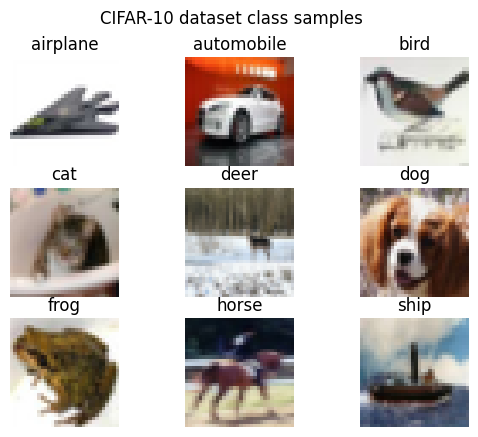

In [4]:
fig, axs = plt.subplots(3, 3)
fig.suptitle('CIFAR-10 dataset class samples')

independent_class_images = dict()

while len(independent_class_images) != 10:
    index = np.random.randint(0, len(cifar_trainset))
    image = cifar_trainset[index]
    independent_class_images[image[1]] = image[0]

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(normalize_img(independent_class_images[i*3+j]))
        axs[i, j].set_title(cifar_trainset.classes[i*3+j])
        axs[i, j].axis('off')

plt.show()

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Base Functions

In [10]:
from torcheval.metrics import MulticlassAccuracy

def train(model: nn.Module, 
          optimizer, 
          criterion, 
          data_loader: torch.utils.data.DataLoader, 
          device,
          n_classes: int,
          verbose=True, verbose_interval=2000):
    acc = MulticlassAccuracy(n_classes, device)

    running_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        acc.update(outputs, labels)
        if verbose and i % verbose_interval == verbose_interval - 1:
            print(f'[{i + 1}, {i + 1:5d}] loss: {running_loss / verbose_interval:.3f}')
            running_loss = 0.0

In [ ]:
def test(model: nn.Module,
         criterion,
         data_loader: torch.utils.DataLoader,
         device,
         n_classes: int,
         verbose=True,
         ):
    accuracy = MulticlassAccuracy(n_classes, device)
    
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(-1, 3, 32, 32), target
            y_true.append(target)

            output = model(data)
            y_pred.append(output)

            test_loss += criterion(output, target).item()

            class_pred = output.argmax(dim=1)

            accuracy.update(class_pred, target)
    
    test_loss /= len(data_loader.dataset)

    return { "test_accuracy": accuracy.compute(), "test_loss": test_loss}

In [ ]:
import config
import torch.optim as optim

def assess_model(model: nn.Module, 
                 criterion, 
                 optimizer,
                 train_loader: torch.utils.data.DataLoader,
                 test_loader: torch.utils.data.DataLoader,
                 config=config,
                 learning_rate: float = 0.01,
                 n_epochs: int = 10,
                 n_classes: int = 10,
                ):
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)

    with wandb.init(project="del-mc1", 
                    name=model.__class__.__name__, 
                    config=config
                    ) as run:
        use_cuda = config["cuda"] and torch.cuda.is_available()
        if config["cuda"] & use_cuda != config["cuda"]:
            print("CUDA running on CPU")
        device = torch.device("cuda" if use_cuda else "cpu")

        model.to(device)

        torch.manual_seed(config["seed"]) 

        for epoch in range(1, config["epochs"] + 1):
            train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes)
            test_metrics = test(model, criterion, test_loader, device, n_classes)
            wandb.log({"epoch": epoch, **train_metrics, **test_metrics})


## Base Model

In [7]:
import torch.nn.functional as F

class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = BaseCNN()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [9]:
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=4, shuffle=False, num_workers=2)

type(trainloader)

torch.utils.data.dataloader.DataLoader

In [66]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.299
[1,  6000] loss: 2.292
[1,  8000] loss: 2.278
[1, 10000] loss: 2.224
[1, 12000] loss: 2.163
[2,  2000] loss: 2.096
[2,  4000] loss: 2.036
[2,  6000] loss: 1.983
[2,  8000] loss: 1.927
[2, 10000] loss: 1.904
[2, 12000] loss: 1.854
[3,  2000] loss: 1.803
[3,  4000] loss: 1.744
[3,  6000] loss: 1.698
[3,  8000] loss: 1.678
[3, 10000] loss: 1.662
[3, 12000] loss: 1.637
[4,  2000] loss: 1.610
[4,  4000] loss: 1.584
[4,  6000] loss: 1.563
[4,  8000] loss: 1.542
[4, 10000] loss: 1.553
[4, 12000] loss: 1.516
[5,  2000] loss: 1.518
[5,  4000] loss: 1.498
[5,  6000] loss: 1.474
[5,  8000] loss: 1.461
[5, 10000] loss: 1.478
[5, 12000] loss: 1.442
Finished Training


In [67]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 47.0 %


In [54]:
# calculate f1 score
from sklearn.metrics import f1_score

y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {f1}')


F1 score: 0.6213904479943029
